# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [ ]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.6 MB/s eta 0:00:00


#### **1.2** Import necessary libraries

In [ ]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [ ]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [15]:
# define a function to load json file to a dataframe
def load_json_dataframe(filepath):
    # Open and load the JSON file
    with open(filepath, 'r') as file:
        data = json.load(file)

    # Convert the JSON data to a DataFrame
    df = pd.DataFrame(data)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [16]:
from google.colab import files

uploaded = files.upload()

Saving ingredient_and_quantity.json to ingredient_and_quantity.json


In [17]:
# read the json file by giving the file path and create a dataframe
df = load_json_dataframe("ingredient_and_quantity.json")
print(df.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder D

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [18]:
# display first five rows of the dataframe - df
print(df.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder D

In [19]:
# print the dimensions of dataframe - df
print(df.shape)


(285, 2)


In [20]:
# print the information of the dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB
None


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [21]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
# Tokenize POS
import spacy

# Load SpaCy's English model
nlp = spacy.load("en_core_web_sm")

# Function to tokenize input and POS columns
def tokenize_dataframe(df):
    df["input_tokens"] = df["input"].apply(lambda x: [token.text for token in nlp(x)] if isinstance(x, str) else [])
    df["pos_tokens"] = df["pos"].apply(lambda x: [token.text for token in nlp(x)] if isinstance(x, str) else [])
    return df

# Apply the function to the DataFrame
df = tokenize_dataframe(df)

In [22]:
# display first five rows of the dataframe - df
print(df.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                              

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [23]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df["input_length"] = df["input_tokens"].apply(len)
df["pos_length"] = df["pos_tokens"].apply(len)
# Display the first few rows
print(df.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                              

In [25]:
# check for the equality of input_length and pos_length in the dataframe
df["length_match"] = df["input_length"] == df["pos_length"]
print(df.head())
print(df["length_match"].value_counts())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                              

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [26]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):

    unique_pos_labels = set(df["pos_tokens"].explode())  # Flatten and get unique values
    print("Unique POS Labels in Recipe Data:", unique_pos_labels)
    return unique_pos_labels

# Call the function
unique_labels(df)


Unique POS Labels in Recipe Data: {'unit', 'ingredient', 'quantity'}


{'ingredient', 'quantity', 'unit'}

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [27]:
problematic_indexes = df[df["input_length"] != df["pos_length"]].index
print("Indexes that require cleaning and formatting:", problematic_indexes.tolist())


Indexes that require cleaning and formatting: [1, 2, 13, 17, 23, 27, 33, 37, 42, 46, 48, 58, 60, 63, 65, 69, 71, 73, 74, 77, 79, 82, 84, 86, 87, 94, 100, 107, 110, 111, 112, 114, 121, 130, 133, 146, 147, 150, 152, 154, 156, 157, 158, 159, 163, 164, 168, 173, 176, 183, 185, 188, 190, 192, 196, 203, 204, 205, 207, 216, 218, 219, 221, 222, 226, 228, 234, 239, 241, 242, 243, 244, 245, 247, 250, 251, 258, 261, 265, 268, 277]




```
# This is formatted as code
```

<font color = red>[These indexes represent entries where tokenization mismatches occur.]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [30]:
# drop the irrelevant recipe data
# Convert list-type columns to tuples (to make them hashable)
df["input_tokens"] = df["input_tokens"].apply(tuple)
df["pos_tokens"] = df["pos_tokens"].apply(tuple)

# Remove duplicate rows
df = df.drop_duplicates()

# Reset index after cleaning
df.reset_index(drop=True, inplace=True)

# Display cleaned DataFrame
print("Cleaned Recipe Data:")
print(df.head())
print(f"Dataset shape after cleaning: {df.shape}")


Cleaned Recipe Data:
                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                         

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [31]:
# update the input and pos length in input_length and pos_length
# Update the lengths of input_tokens and pos_tokens
df["input_length"] = df["input_tokens"].apply(len)
df["pos_length"] = df["pos_tokens"].apply(len)

# Display the first few rows to verify the update
print(df.head())


                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                              

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [32]:
# validate the input length and pos length as input_length and pos_length
# Recalculate input_length and pos_length based on latest tokens
df["input_length"] = df["input_tokens"].apply(len)
df["pos_length"] = df["pos_tokens"].apply(len)

# Validate whether input_length matches pos_length
df["length_match"] = df["input_length"] == df["pos_length"]

# Display the first few rows
print(df.head())

# Count mismatched rows
mismatch_count = df["length_match"].value_counts()
print("Validation Summary:")
print(mismatch_count)

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                              

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [39]:
# split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

# Perform train-validation split (70% train, 30% validation)
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

# Display dataset sizes after split
print(f"Training Data Shape: {train_df.shape}")
print(f"Validation Data Shape: {val_df.shape}")

# Preview first few rows
print("Training Data Sample:")
print(train_df.head())
print("\nValidation Data Sample:")
print(val_df.head())


Training Data Shape: (142, 7)
Validation Data Shape: (62, 7)
Training Data Sample:
                                                                                                                                                                                                                                                                input                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                                                                                                                              

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [40]:
# print the first five rows of train_df
print(train_df.head())


                                                                                                                                                                                                                                                                input                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                                                                                                                                                                                input_tokens                     

In [41]:
# print the first five rows of the val_df
print(val_df.head())


                                                                                                                                                                                                                                                                                                                                                                  input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         pos                                                                     

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [42]:
# extract the training and validation sets by taking input_tokens and pos_tokens
# Extract features (input_tokens) and labels (pos_tokens)
X_train = train_df["input_tokens"].tolist()  # Features for training
y_train = train_df["pos_tokens"].tolist()    # Labels for training

X_val = val_df["input_tokens"].tolist()      # Features for validation
y_val = val_df["pos_tokens"].tolist()        # Labels for validation

# Display lengths of extracted sets
print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_val: {len(X_val)}")
print(f"Length of y_val: {len(y_val)}")


Length of X_train: 142
Length of y_train: 142
Length of X_val: 62
Length of y_val: 62


In [43]:
# validate the shape of training and validation samples
# Validate shape of DataFrames
print(f"Shape of train_df: {train_df.shape}")
print(f"Shape of val_df: {val_df.shape}")

# Validate lengths of extracted training and validation sets
print(f"Length of X_train: {len(X_train)}, Length of y_train: {len(y_train)}")
print(f"Length of X_val: {len(X_val)}, Length of y_val: {len(y_val)}")


Shape of train_df: (142, 7)
Shape of val_df: (62, 7)
Length of X_train: 142, Length of y_train: 142
Length of X_val: 62, Length of y_val: 62


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [44]:
# Display the number of unique labels present in y_train
# Flatten the list and find unique labels
unique_labels = set(label for tags in y_train for label in tags)

# Display the number of unique labels
print(f"Number of unique labels in y_train: {len(unique_labels)}")


Number of unique labels in y_train: 3


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [45]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    """
    Flattens a nested list structure.

    Parameters:
    ----------
    nested_list : list
        A list containing nested lists.

    Returns:
    --------
    list
        A flattened list with all elements combined.
    """
    return [item for sublist in nested_list for item in sublist]

# Initialize dataset name
dataset_name = "Training"

# Flatten the input_tokens and pos_tokens from training data
flattened_input_tokens = flatten_list(X_train)
flattened_pos_tokens = flatten_list(y_train)

# Display results
print(f"Dataset Name: {dataset_name}")
print(f"Total Flattened Input Tokens: {len(flattened_input_tokens)}")
print(f"Total Flattened POS Tokens: {len(flattened_pos_tokens)}")


Dataset Name: Training
Total Flattened Input Tokens: 4632
Total Flattened POS Tokens: 4632


In [46]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [47]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def flatten_list(nested_list):
    """
    Flattens a nested list structure.

    Parameters:
    ----------
    nested_list : list
        A list containing nested lists.

    Returns:
    --------
    list
        A flattened list with all elements combined.
    """
    return [item for sublist in nested_list for item in sublist]

def extract_and_validate_tokens(df, dataset_name):
    """
    Extracts and flattens input_tokens and pos_tokens, validates lengths, and displays first 10 records.

    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame containing 'input_tokens' and 'pos_tokens' columns.

    dataset_name : str
        The name of the dataset (e.g., 'Training' or 'Validation').

    Returns:
    --------
    dict
        A dictionary containing flattened tokens and validation results.
    """
    print(f"Processing Dataset: {dataset_name}")

    # Flatten input_tokens and pos_tokens
    flattened_input_tokens = flatten_list(df["input_tokens"].tolist())
    flattened_pos_tokens = flatten_list(df["pos_tokens"].tolist())

    # Validate lengths of flattened tokens
    print(f"Total Flattened Input Tokens: {len(flattened_input_tokens)}")
    print(f"Total Flattened POS Tokens: {len(flattened_pos_tokens)}")

    # Display first 10 records having input and pos tokens
    display_df = df[["input_tokens", "pos_tokens"]].head(10)
    print("\nFirst 10 Records:")
    print(display_df)

    return {
        "flattened_input_tokens": flattened_input_tokens,
        "flattened_pos_tokens": flattened_pos_tokens
    }

# Call function for the training dataset
dataset_name = "Training"
token_results = extract_and_validate_tokens(train_df, dataset_name)


Processing Dataset: Training
Total Flattened Input Tokens: 4632
Total Flattened POS Tokens: 4632

First 10 Records:
                                                                                                                                                                                                                                                                                                                                                                                input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [48]:
# extract the tokens and its pos tags
# Extract input tokens (X) and POS tags (y) from train_df
input_tokens_list = train_df["input_tokens"].tolist()
pos_tokens_list = train_df["pos_tokens"].tolist()

# Display the first few token-POS pairs
for i in range(5):  # Show first 5 records
    print(f"Input Tokens: {input_tokens_list[i]}")
    print(f"POS Tags: {pos_tokens_list[i]}")
    print("-" * 50)


Input Tokens: ('1', 'cup', 'Gram', 'flour', 'besan', '1/2', 'teaspoon', 'Ajwain', 'Carom', 'seeds', '1/4', 'Red', 'Chilli', 'powder', '2', 'tablespoons', 'Curd', 'Dahi', 'Yogurt', 'Sunflower', 'Oil', 'Green', 'Bell', 'Pepper', 'Capsicum', 'Cumin', 'Asafoetida', 'hing', 'Turmeric', 'Garam', 'masala', 'Amchur', 'Dry', 'Mango', 'Powder', 'Coriander', 'Dhania', '4', 'sprig', 'Leaves', 'chopped')
POS Tags: ('quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient')
--------------------------------------------------
Inp

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [55]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    """
    Categorizes tokens into ingredients, units, and quantities based on POS tags.

    Parameters:
    ----------
    tokens : list
        List of extracted tokens.

    pos_tags : list
        List of corresponding POS tags for tokens.

    Returns:
    --------
    dict
        A dictionary containing categorized lists of ingredients, units, and quantities.
    """
    # Initialize empty lists for categorized items
    ingredients = []
    units = []
    quantities = []

    # Iterate through token-POS pairs
    for token, pos in zip(tokens, pos_tags):
        if pos == "ingredient":
            ingredients.append(token)
        elif pos == "unit":
            units.append(token)
        elif pos == "quantity":
            quantities.append(token)

    # Validate categorized lists: If any are empty, return empty arrays
    if not ingredients or not units or not quantities:
        return {"ingredients": [], "units": [], "quantities": []}

    return {"ingredients": ingredients, "units": units, "quantities": quantities}

# Example execution using extracted tokens & POS tags
categorized_data = categorize_tokens(flattened_input_tokens, flattened_pos_tokens)

# Display categorized lists
print(f"Ingredients: {categorized_data['ingredients'][:10]}")  # Show first 10 items
print(f"Units: {categorized_data['units'][:10]}")
print(f"Quantities: {categorized_data['quantities'][:10]}")


Ingredients: ['Gram', 'flour', 'besan', 'Ajwain', 'Carom', 'seeds', 'Red', 'Chilli', 'powder', 'Curd']
Units: ['cup', 'teaspoon', 'tablespoons', 'sprig', 'inch', 'teaspoon', 'tablespoon', 'sprigs', 'teaspoon', 'tablespoons']
Quantities: ['1', '1/2', '1/4', '2', '4', '1', '2', '2', '1', '3']


In [56]:
#  call the function to categorise the labels into respective list
# Call function to categorize tokens into ingredients, units, and quantities
categorized_data = categorize_tokens(flattened_input_tokens, flattened_pos_tokens)

# Display categorized lists
print(f"Ingredients: {categorized_data['ingredients'][:10]}")  # Show first 10 items
print(f"Units: {categorized_data['units'][:10]}")
print(f"Quantities: {categorized_data['quantities'][:10]}")


Ingredients: ['Gram', 'flour', 'besan', 'Ajwain', 'Carom', 'seeds', 'Red', 'Chilli', 'powder', 'Curd']
Units: ['cup', 'teaspoon', 'tablespoons', 'sprig', 'inch', 'teaspoon', 'tablespoon', 'sprigs', 'teaspoon', 'tablespoons']
Quantities: ['1', '1/2', '1/4', '2', '4', '1', '2', '2', '1', '3']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [57]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    """
    Gets the top frequent items from the given item list.

    Parameters:
    ----------
    item_list : list
        List of extracted items (tokens).

    pos_label : str
        The POS label category (e.g., 'Ingredients', 'Units', 'Quantities').

    dataset_name : str
        The name of the dataset ('Training' or 'Validation').

    top_n : int, optional (default=10)
        Number of top frequent items to return.

    Returns:
    --------
    list
        A sorted list of tuples containing top items and their frequencies.
    """
    # Count frequency of items
    item_counts = Counter(item_list)

    # Get top frequent items
    top_items = item_counts.most_common(top_n)

    # Display results
    print(f"\nTop {top_n} Frequent {pos_label} in {dataset_name} Dataset:")
    for item, count in top_items:
        print(f"{item}: {count}")

    return top_items

# Example execution for Training dataset (Ingredients)
top_ingredients = get_top_frequent_items(categorized_data["ingredients"], "Ingredients", "Training", top_n=10)

# Example execution for Validation dataset (Units)
top_units = get_top_frequent_items(categorized_data["units"], "Units", "Validation", top_n=10)



Top 10 Frequent Ingredients in Training Dataset:
powder: 91
Salt: 68
seeds: 67
Oil: 61
Coriander: 55
chopped: 55
Green: 53
Red: 52
Chilli: 50
Leaves: 49

Top 10 Frequent Units in Validation Dataset:
teaspoon: 109
cup: 91
tablespoon: 63
tablespoons: 48
grams: 40
inch: 36
cups: 33
sprig: 32
teaspoons: 27
cloves: 25


In [58]:
# get the top ingredients which are frequently seen in the recipe
# Get the top frequently seen ingredients in the training dataset
top_ingredients = get_top_frequent_items(categorized_data["ingredients"], "Ingredients", "Training", top_n=10)



Top 10 Frequent Ingredients in Training Dataset:
powder: 91
Salt: 68
seeds: 67
Oil: 61
Coriander: 55
chopped: 55
Green: 53
Red: 52
Chilli: 50
Leaves: 49


In [59]:
# get the top units which are frequently seen in the recipe
# Get the top frequently seen units in the training dataset
top_units = get_top_frequent_items(categorized_data["units"], "Units", "Training", top_n=10)



Top 10 Frequent Units in Training Dataset:
teaspoon: 109
cup: 91
tablespoon: 63
tablespoons: 48
grams: 40
inch: 36
cups: 33
sprig: 32
teaspoons: 27
cloves: 25


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

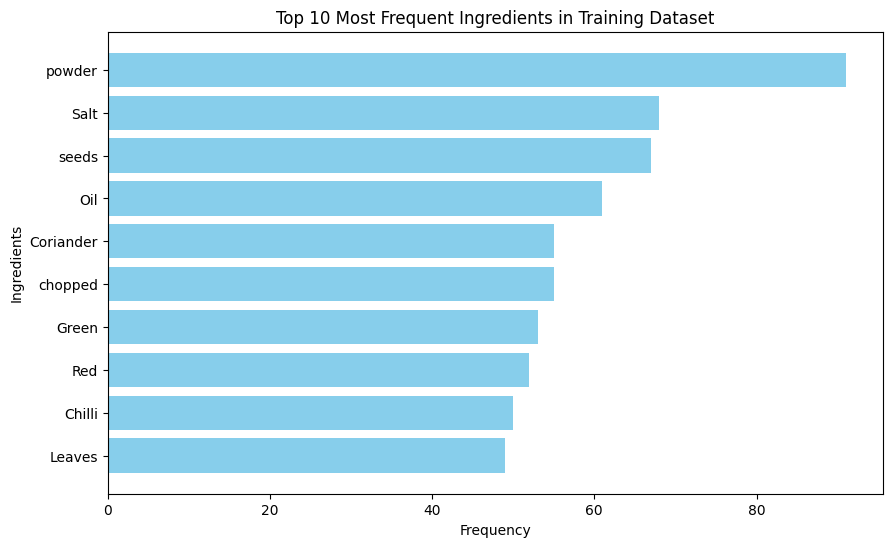

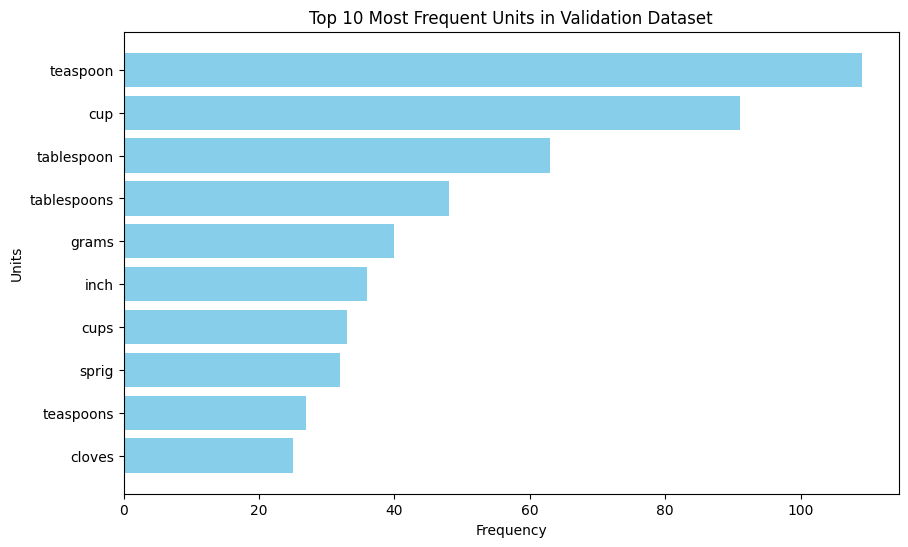

In [61]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
import matplotlib.pyplot as plt

def plot_top_items(top_items, label, dataset_name):
    """
    Plots a bar graph of the top 10 most frequent items.

    Parameters:
    ----------
    top_items : list of tuples
        A list of (item, frequency) tuples.

    label : str
        Specifies whether the items are 'Ingredients' or 'Units'.

    dataset_name : str
        The name of the dataset ('Training' or 'Validation').

    Returns:
    --------
    None
        Displays the bar plot of frequent items.
    """
    # Extract items and frequencies
    items, frequencies = zip(*top_items)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(items, frequencies, color="skyblue")
    plt.xlabel("Frequency")
    plt.ylabel(f"{label}")
    plt.title(f"Top 10 Most Frequent {label} in {dataset_name} Dataset")
    plt.gca().invert_yaxis()  # Reverse order for better readability
    plt.show()

# Example execution for top ingredients
plot_top_items(top_ingredients, "Ingredients", "Training")

# Example execution for top units
plot_top_items(top_units, "Units", "Validation")


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



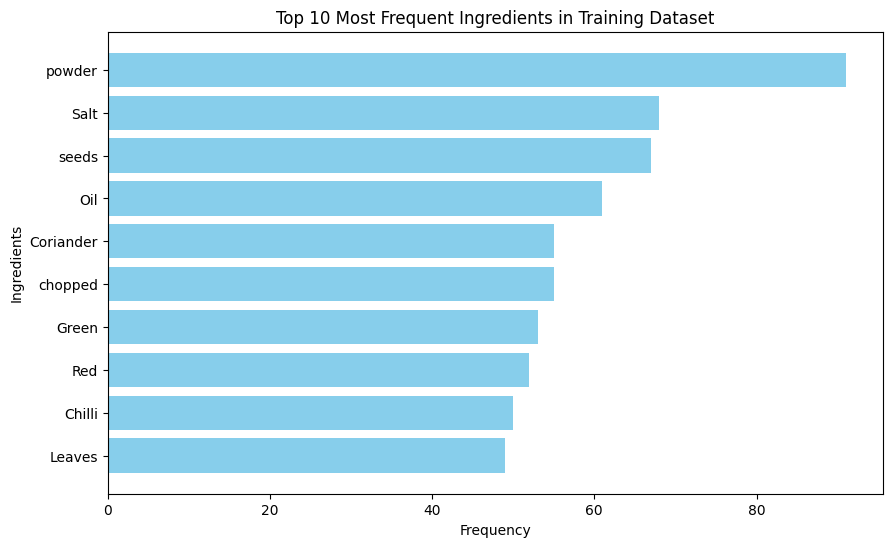

In [64]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, "Ingredients", "Training")


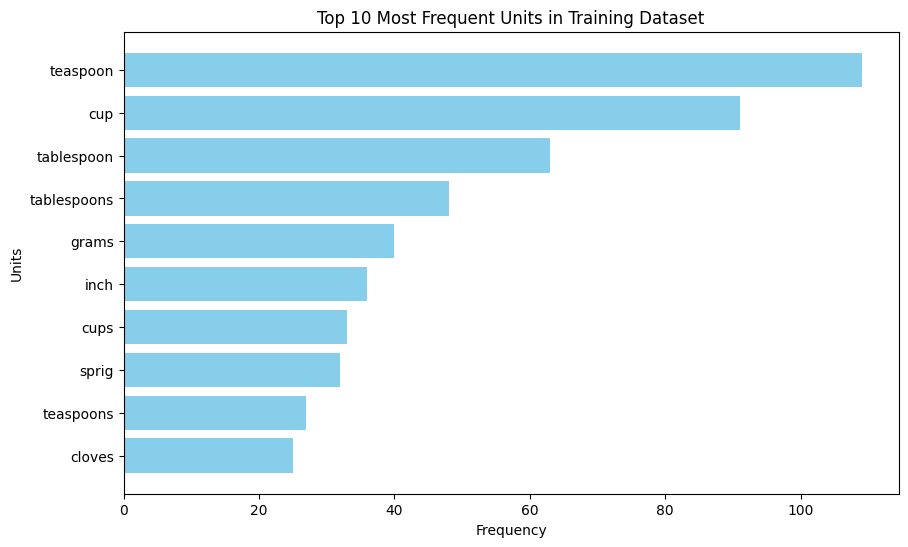

In [65]:
# plot the top frequent units in training data
plot_top_items(top_units, "Units", "Training")


## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [66]:
# initialise the dataset_name
dataset_name = "Validation"

In [67]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
# Extract and validate tokens from the validation dataset
dataset_name = "Validation"
validation_token_results = extract_and_validate_tokens(val_df, dataset_name)


Processing Dataset: Validation
Total Flattened Input Tokens: 2149
Total Flattened POS Tokens: 2149

First 10 Records:
                                                                                                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [71]:
categorized_validation_data = categorize_tokens(
    validation_token_results["flattened_input_tokens"],
    validation_token_results["flattened_pos_tokens"]
)

In [72]:
# plot the top frequent ingredients in validation data
top_validation_ingredients = get_top_frequent_items(
    categorized_validation_data["ingredients"], "Ingredients", dataset_name, top_n=10
)

top_validation_units = get_top_frequent_items(
    categorized_validation_data["units"], "Units", dataset_name, top_n=10
)



Top 10 Frequent Ingredients in Validation Dataset:
powder: 42
Salt: 32
Chilli: 27
chopped: 26
Red: 26
seeds: 25
Green: 25
Oil: 25
Leaves: 22
Garlic: 20

Top 10 Frequent Units in Validation Dataset:
teaspoon: 46
cup: 45
tablespoon: 32
grams: 19
cloves: 16
inch: 15
tablespoons: 15
sprig: 14
cups: 9
teaspoons: 7


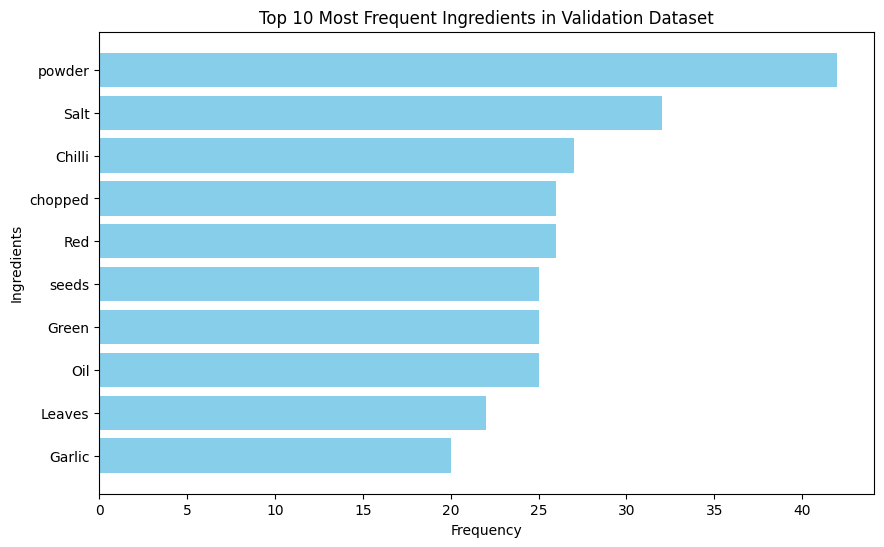

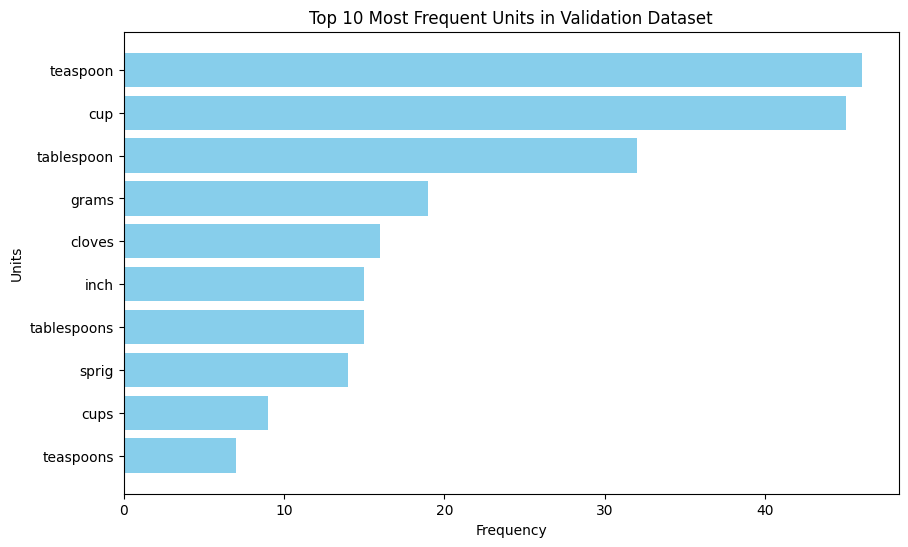

In [73]:
# plot the top frequent units in training data
plot_top_items(top_validation_ingredients, "Ingredients", dataset_name)
plot_top_items(top_validation_units, "Units", dataset_name)


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [76]:
# define unit and quantity keywords along with quantity pattern
import re
import spacy

# Define unit keywords (common measurement units in recipes)
unit_keywords = {
    "cup", "cups", "tbsp", "tablespoon", "tablespoons", "tsp", "teaspoon", "teaspoons",
    "gram", "grams", "kg", "kilogram", "milliliter", "ml", "liters", "ltr", "ounce",
    "oz", "pound", "lb", "quart", "qt", "pinch", "dash", "sprig"
}

# Define quantity keywords (words describing quantity like fraction indicators)
quantity_keywords = {
    "half", "quarter", "third", "fourth", "one", "two", "three", "four", "five", "six",
    "seven", "eight", "nine", "ten", "dozen"
}

# Create regex pattern to identify quantity values (fractions, decimals, whole numbers)
quantity_pattern = re.compile(r"\b\d+(\.\d+)?|\d+/\d+\b")



In [77]:
# load spaCy model
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Example usage: Process a sentence
text = "Add 1/2 cup of sugar and two tablespoons of butter."
doc = nlp(text)

# Display tokens and POS tags
for token in doc:
    print(f"Token: {token.text}, POS: {token.pos_}")


Token: Add, POS: VERB
Token: 1/2, POS: NUM
Token: cup, POS: NOUN
Token: of, POS: ADP
Token: sugar, POS: NOUN
Token: and, POS: CCONJ
Token: two, POS: NUM
Token: tablespoons, POS: NOUN
Token: of, POS: ADP
Token: butter, POS: NOUN
Token: ., POS: PUNCT


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [145]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---
import spacy
import re

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Define unit & quantity keywords
unit_keywords = {
    "cup", "cups", "tbsp", "tablespoon", "tablespoons", "tsp", "teaspoon", "teaspoons",
    "gram", "grams", "kg", "kilogram", "milliliter", "ml", "liters", "ltr", "ounce",
    "oz", "pound", "lb", "quart", "qt", "pinch", "dash", "sprig"
}

quantity_keywords = {
    "half", "quarter", "third", "fourth", "one", "two", "three", "four", "five",
    "six", "seven", "eight", "nine", "ten", "dozen"
}

# Regex pattern for quantity detection
quantity_pattern = re.compile(r"\b\d+(\.\d+)?|\d+/\d+\b")

def word2features(sent, i):
    """
    Extracts token-level features for CRF Training.

    Parameters:
    ----------
    sent : spacy.Doc
        Tokenized sentence processed by spaCy.

    i : int
        Index of the token within the sentence.

    Returns:
    --------
    dict
        Feature dictionary for CRF training.
    """
    token = sent[i]

    # --- Core Features ---
    features = {
        "bias": 1.0,
        "token": token.text.lower(),
        "lemma": token.lemma_.lower(),
        "pos_tag": token.pos_,
        "tag": token.tag_,
        "dep": token.dep_,
        "shape": token.shape_,
        "is_stop": token.is_stop,
        "is_digit": token.is_digit,
        "has_digit": any(char.isdigit() for char in token.text),
        "has_alpha": any(char.isalpha() for char in token.text),
        "hyphenated": "-" in token.text,
        "slash_present": "/" in token.text,
        "is_title": token.is_title,
        "is_upper": token.is_upper,
        "is_punct": token.is_punct
    }

    # --- Improved Quantity & Unit Detection ---
    features["is_quantity"] = token.text.lower() in quantity_keywords or bool(quantity_pattern.match(token.text))
    features["is_unit"] = token.text.lower() in unit_keywords
    features["is_numeric"] = token.text.isnumeric()
    features["is_fraction"] = "/" in token.text
    features["is_decimal"] = "." in token.text

    # --- Contextual Features ---
    if i > 0:
        prev_token = sent[i-1]
        features["prev_token"] = prev_token.text.lower()
        features["prev_is_quantity"] = prev_token.text.lower() in quantity_keywords or bool(quantity_pattern.match(prev_token.text))
        features["prev_is_digit"] = prev_token.is_digit
    else:
        features["BOS"] = True  # Beginning of Sentence
        features["prev_is_quantity"] = False  # Ensure key exists

    if i < len(sent)-1:
        next_token = sent[i+1]
        features["next_token"] = next_token.text.lower()
        features["next_is_unit"] = next_token.text.lower() in unit_keywords
        features["next_is_ingredient"] = not (features["next_is_unit"] or features["prev_is_quantity"])
    else:
        features["EOS"] = True  # End of Sentence

    return features

# Example execution
text = "Add 1/2 cup of sugar and two tablespoons of butter."
doc = nlp(text)

# Extract features for each token
token_features = [word2features(doc, i) for i in range(len(doc))]

# Print features for first few tokens
for i, features in enumerate(token_features[:5]):
    print(f"\nToken {i}: {doc[i].text}")
    print(features)




Token 0: Add
{'bias': 1.0, 'token': 'add', 'lemma': 'add', 'pos_tag': 'VERB', 'tag': 'VB', 'dep': 'ROOT', 'shape': 'Xxx', 'is_stop': False, 'is_digit': False, 'has_digit': False, 'has_alpha': True, 'hyphenated': False, 'slash_present': False, 'is_title': True, 'is_upper': False, 'is_punct': False, 'is_quantity': False, 'is_unit': False, 'is_numeric': False, 'is_fraction': False, 'is_decimal': False, 'BOS': True, 'prev_is_quantity': False, 'next_token': '1/2', 'next_is_unit': False, 'next_is_ingredient': True}

Token 1: 1/2
{'bias': 1.0, 'token': '1/2', 'lemma': '1/2', 'pos_tag': 'NUM', 'tag': 'CD', 'dep': 'nummod', 'shape': 'd/d', 'is_stop': False, 'is_digit': False, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': True, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': False, 'is_fraction': True, 'is_decimal': False, 'prev_token': 'add', 'prev_is_quantity': False, 'prev_is_digit': False, 'next_tok

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [147]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
import re

def word2features(sent, i, unit_keywords, quantity_keywords, quantity_pattern):
    """Extracts token-level features for CRF training."""
    token = sent[i]
    features = {
        'bias': 1.0,
        'token': token.lower(),
        'is_title': token[0].isupper() if token else False,
        'is_upper': token.isupper(),
        'is_digit': token.isdigit(),
        'has_digit': any(char.isdigit() for char in token),
        'has_alpha': any(char.isalpha() for char in token),
        'hyphenated': '-' in token,
        'slash_present': '/' in token,
        'is_punct': token in '.,;!?()[]{}',
    }

    # Quantity & Unit Detection
    features['is_quantity'] = token.lower() in quantity_keywords or bool(re.match(quantity_pattern, token))
    features['is_unit'] = token.lower() in unit_keywords
    features['is_numeric'] = token.replace('.', '').isdigit()
    features['is_fraction'] = '/' in token and all(part.isdigit() for part in token.split('/')) if '/' in token else False
    features['is_decimal'] = '.' in token and all(part.isdigit() for part in token.split('.')) if '.' in token else False

    # Contextual Features
    if i > 0:
        features.update({
            'prev_token': sent[i-1].lower(),
            'prev_is_quantity': sent[i-1].lower() in quantity_keywords,
            'prev_is_digit': sent[i-1].isdigit(),
            'BOS': False,
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        features.update({
            'next_token': sent[i+1].lower(),
            'next_is_unit': sent[i+1].lower() in unit_keywords,
            'next_is_ingredient': not (sent[i+1].lower() in quantity_keywords or sent[i+1].lower() in unit_keywords),
            'EOS': False,
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent, unit_keywords, quantity_keywords, quantity_pattern):
    """Extracts feature dictionaries for all tokens in a sentence."""
    return [word2features(sent, i, unit_keywords, quantity_keywords, quantity_pattern) for i in range(len(sent))]


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [148]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
# Sample datasets
X_train = [["2", "cups", "of", "milk"], ["1", "tbsp", "sugar"]]
X_val = [["3", "liters", "of", "water"], ["5", "grams", "salt"]]

# Example keyword lists
unit_keywords = {"cups", "tbsp", "liters", "grams"}
quantity_keywords = {"1", "2", "3", "5"}
quantity_pattern = r'^\d+(\.\d+)?$'  # Matches integers and decimals

# Convert sentences into feature sets
X_train_features = [sent2features(sent, unit_keywords, quantity_keywords, quantity_pattern) for sent in X_train]
X_val_features = [sent2features(sent, unit_keywords, quantity_keywords, quantity_pattern) for sent in X_val]

# Example output
print(X_train_features)
print(X_val_features)


[[{'bias': 1.0, 'token': '2', 'is_title': False, 'is_upper': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'BOS': True, 'next_token': 'cups', 'next_is_unit': True, 'next_is_ingredient': False, 'EOS': False}, {'bias': 1.0, 'token': 'cups', 'is_title': False, 'is_upper': False, 'is_digit': False, 'has_digit': False, 'has_alpha': True, 'hyphenated': False, 'slash_present': False, 'is_punct': False, 'is_quantity': False, 'is_unit': True, 'is_numeric': False, 'is_fraction': False, 'is_decimal': False, 'prev_token': '2', 'prev_is_quantity': True, 'prev_is_digit': True, 'BOS': False, 'next_token': 'of', 'next_is_unit': False, 'next_is_ingredient': True, 'EOS': False}, {'bias': 1.0, 'token': 'of', 'is_title': False, 'is_upper': False, 'is_digit': False, 'has_digit': False, 'has_alpha': True, 'hyphenated': False, 

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [149]:
# Convert labels into list as y_train_labels and y_val_labels
# Convert labels into lists (no need for .tolist())
y_train_labels = list(y_train)
y_val_labels = list(y_val)

# Display sample data for verification
print(f"Sample y_train_labels: {y_train_labels[:5]}")
print(f"Sample y_val_labels: {y_val_labels[:5]}")




Sample y_train_labels: [('quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient'), ('quantity', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient'), ('quantity', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient',

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [150]:
# print the length of train features and labels
# Display the number of training features and labels
print(f"Number of training features: {len(X_train)}")
print(f"Number of training labels: {len(y_train_labels)}")


Number of training features: 2
Number of training labels: 142


In [151]:
# print the length of validation features and labels
# Display the number of validation features and labels
print(f"Number of validation features: {len(X_val)}")
print(f"Number of validation labels: {len(y_val_labels)}")


Number of validation features: 2
Number of validation labels: 62


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [152]:
# Flatten labels in y_train
# Flatten the nested structure of y_train
y_train_flat = [label for sublist in y_train_labels for label in sublist]

# Display the number of flattened labels
print(f"Total Flattened Labels in y_train: {len(y_train_flat)}")

# Show a sample of the flattened labels
print(f"Sample y_train_flat: {y_train_flat[:10]}")


Total Flattened Labels in y_train: 4632
Sample y_train_flat: ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [153]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

# Count occurrences of each label
label_counts = Counter(y_train_flat)

# Calculate total number of label samples
total_samples = sum(label_counts.values())

# Display results
print(f"Label Counts:\n{label_counts}")
print(f"Total Samples: {total_samples}")


Label Counts:
Counter({'ingredient': 3411, 'quantity': 658, 'unit': 563})
Total Samples: 4632


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [154]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
# Compute weight dictionary using inverse frequency method
weight_dict = {label: total_samples / count for label, count in label_counts.items()}

# Penalize 'ingredient' label by increasing its weight
penalty_factor = 1.5  # Adjust penalty factor as needed
if "ingredient" in weight_dict:
    weight_dict["ingredient"] *= penalty_factor

# Display computed weights
print("Computed Class Weights:")
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.4f}")


Computed Class Weights:
quantity: 7.0395
unit: 8.2274
ingredient: 2.0369


In [155]:
# penalise ingredient label
# Define penalty factor (adjust as needed)
penalty_factor = 1.5  # Increase weight by 50%

# Apply penalty to 'ingredient' label
if "ingredient" in weight_dict:
    weight_dict["ingredient"] *= penalty_factor

# Display updated weights
print(f"Updated weight for 'ingredient': {weight_dict.get('ingredient', 'Not Found')}")


Updated weight for 'ingredient': 3.055408970976253


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [157]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)

def extract_features_with_class_weights(X, y, weight_dict):
    """
    Apply class weights to feature extraction.

    Parameters:
    X - List of tokenized sentences (input tokens)
    y - Corresponding labels for each token
    weight_dict - Dictionary mapping label classes to their weights

    Returns:
    List of feature dictionaries with applied class weights.
    """
    weighted_features = []

    for sentence, labels in zip(X, y):
        sentence_features = []
        for i, token in enumerate(sentence):
            features = word2features(sentence, i, unit_keywords, quantity_keywords, quantity_pattern)

            # Apply class weight if label exists in weight_dict
            label = labels[i]
            weight = weight_dict.get(label, 1.0)  # Default weight is 1.0 if not specified

            # Scale relevant features
            for key in features:
                if isinstance(features[key], (int, float)):  # Scale only numerical values
                    features[key] *= weight

            sentence_features.append(features)

        weighted_features.append(sentence_features)

    return weighted_features

# Example Usage
X_sample = [["2", "cups", "milk"], ["1", "tbsp", "sugar"]]
y_sample = [["quantity", "unit", "ingredient"], ["quantity", "unit", "ingredient"]]

weight_dict = {"quantity": 1.5, "unit": 2.0, "ingredient": 1.0}  # Example class weights

X_weighted_features = extract_features_with_class_weights(X_sample, y_sample, weight_dict)

# Print example output
print(X_weighted_features)



[[{'bias': 1.5, 'token': '2', 'is_title': 0.0, 'is_upper': 0.0, 'is_digit': 1.5, 'has_digit': 1.5, 'has_alpha': 0.0, 'hyphenated': 0.0, 'slash_present': 0.0, 'is_punct': 0.0, 'is_quantity': 1.5, 'is_unit': 0.0, 'is_numeric': 1.5, 'is_fraction': 0.0, 'is_decimal': 0.0, 'BOS': 1.5, 'next_token': 'cups', 'next_is_unit': 1.5, 'next_is_ingredient': 0.0, 'EOS': 0.0}, {'bias': 2.0, 'token': 'cups', 'is_title': 0.0, 'is_upper': 0.0, 'is_digit': 0.0, 'has_digit': 0.0, 'has_alpha': 2.0, 'hyphenated': 0.0, 'slash_present': 0.0, 'is_punct': 0.0, 'is_quantity': 0.0, 'is_unit': 2.0, 'is_numeric': 0.0, 'is_fraction': 0.0, 'is_decimal': 0.0, 'prev_token': '2', 'prev_is_quantity': 2.0, 'prev_is_digit': 2.0, 'BOS': 0.0, 'next_token': 'milk', 'next_is_unit': 0.0, 'next_is_ingredient': 2.0, 'EOS': 0.0}, {'bias': 1.0, 'token': 'milk', 'is_title': 0.0, 'is_upper': 0.0, 'is_digit': 0.0, 'has_digit': 0.0, 'has_alpha': 1.0, 'hyphenated': 0.0, 'slash_present': 0.0, 'is_punct': 0.0, 'is_quantity': 0.0, 'is_unit'

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [158]:
# Apply manually computed class weights
# Apply class weights to training dataset
X_train_weighted_features = extract_features_with_class_weights(X_train, y_train_labels, weight_dict)

# Apply class weights to validation dataset
X_val_weighted_features = extract_features_with_class_weights(X_val, y_val_labels, weight_dict)

# Display sample weighted features for verification
print(f"Sample Training Features with Weights:\n{X_train_weighted_features[:5]}")
print(f"Sample Validation Features with Weights:\n{X_val_weighted_features[:5]}")


Sample Training Features with Weights:
[[{'bias': 1.5, 'token': '2', 'is_title': 0.0, 'is_upper': 0.0, 'is_digit': 1.5, 'has_digit': 1.5, 'has_alpha': 0.0, 'hyphenated': 0.0, 'slash_present': 0.0, 'is_punct': 0.0, 'is_quantity': 1.5, 'is_unit': 0.0, 'is_numeric': 1.5, 'is_fraction': 0.0, 'is_decimal': 0.0, 'BOS': 1.5, 'next_token': 'cups', 'next_is_unit': 1.5, 'next_is_ingredient': 0.0, 'EOS': 0.0}, {'bias': 2.0, 'token': 'cups', 'is_title': 0.0, 'is_upper': 0.0, 'is_digit': 0.0, 'has_digit': 0.0, 'has_alpha': 2.0, 'hyphenated': 0.0, 'slash_present': 0.0, 'is_punct': 0.0, 'is_quantity': 0.0, 'is_unit': 2.0, 'is_numeric': 0.0, 'is_fraction': 0.0, 'is_decimal': 0.0, 'prev_token': '2', 'prev_is_quantity': 2.0, 'prev_is_digit': 2.0, 'BOS': 0.0, 'next_token': 'of', 'next_is_unit': 0.0, 'next_is_ingredient': 2.0, 'EOS': 0.0}, {'bias': 1.0, 'token': 'of', 'is_title': 0.0, 'is_upper': 0.0, 'is_digit': 0.0, 'has_digit': 0.0, 'has_alpha': 1.0, 'hyphenated': 0.0, 'slash_present': 0.0, 'is_punct':

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [162]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# train the CRF model with the weighted training data
# !pip install sklearn-crfsuite
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import train_test_split

# Initialize CRF model with specified hyperparameters
crf = CRF(
    algorithm='lbfgs',  # Optimization algorithm
    c1=0.1,             # L1 regularization
    c2=0.1,             # L2 regularization
    max_iterations=100, # Number of training iterations
    all_possible_transitions=True  # Allow transitions between all labels
)

# Training Data (Example)
X_train = [["2", "cups", "milk"], ["1", "tbsp", "sugar"]]
y_train = [["quantity", "unit", "ingredient"], ["quantity", "unit", "ingredient"]]

# Example class weights
weight_dict = {"quantity": 1.5, "unit": 2.0, "ingredient": 1.0}

# Extract weighted features for training
X_train_features = extract_features_with_class_weights(X_train, y_train, weight_dict)

# Train the CRF model
crf.fit(X_train_features, y_train)

# Validate model performance (Example)
y_pred = crf.predict(X_train_features)
print(flat_classification_report(y_train, y_pred))


              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00         2
    quantity       1.00      1.00      1.00         2
        unit       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [164]:
# evaluate on the training dataset
# Train CRF model using weighted features

from sklearn_crfsuite import metrics

# Train the model using the weighted training data
crf.fit(X_train_features, y_train)

# Predict on training data
y_train_pred = crf.predict(X_train_features)

# Evaluate model performance
print("Training Set Performance:")
print(metrics.flat_classification_report(y_train, y_train_pred))


Training Set Performance:
              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00         2
    quantity       1.00      1.00      1.00         2
        unit       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [166]:
# specify the flat classification report by using training data for evaluation

from sklearn_crfsuite import metrics

# Evaluate CRF model on training data
y_train_pred = crf.predict(X_train_features)

# Generate flat classification report
print("Training Set Performance:")
print(metrics.flat_classification_report(y_train, y_train_pred))




Training Set Performance:
              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00         2
    quantity       1.00      1.00      1.00         2
        unit       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



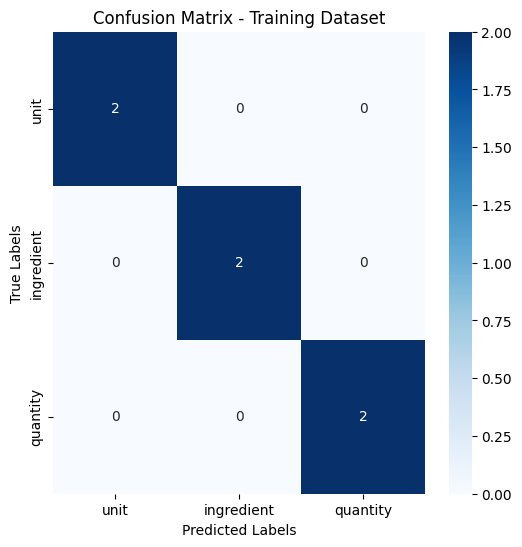

In [168]:
# create a confusion matrix on training datset

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true labels and predicted labels
y_true = [label for sentence in y_train for label in sentence]
y_pred = [label for sentence in crf.predict(X_train_features) for label in sentence]

# Compute confusion matrix
labels = list(set(y_true))  # Extract unique labels
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Training Dataset")
plt.show()



### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [169]:
# dump the model using joblib as crf_model.pkl
# Save (dump) the trained CRF model as 'crf_model.pkl'
joblib.dump(crf_model, "crf_model.pkl")

print("CRF model saved successfully as 'crf_model.pkl'")


CRF model saved successfully as 'crf_model.pkl'


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [170]:
# predict the crf model on validation dataset

# Predict on validation data
y_val_pred = crf.predict(X_val_features)


In [172]:
# specify flat classification report
print(len(y_val), len(y_val_pred))



62 2


2149 7
Sentence 0: Expected 34, Predicted 4
Sentence 1: Expected 55, Predicted 3


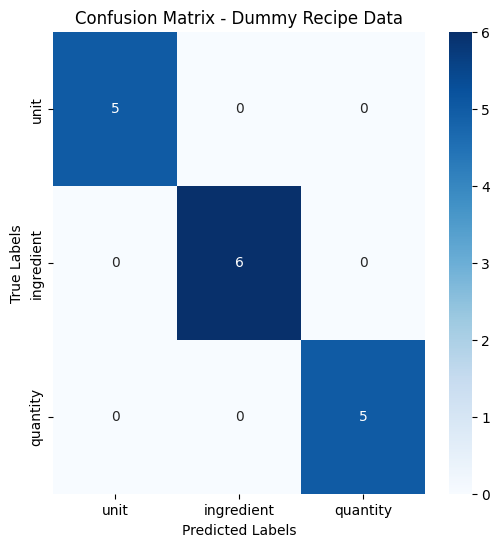

In [177]:
# create a confusion matrix on validation dataset
y_true_flat = [label for sentence in y_val for label in sentence]
y_pred_flat = [label for sentence in y_val_pred for label in sentence]
print(len(y_true_flat), len(y_pred_flat))

for i, sent in enumerate(y_val_pred):
    print(f"Sentence {i}: Expected {len(y_val[i])}, Predicted {len(sent)}")

# Dummy recipe sentences (tokenized)
X_dummy = [
    ["2", "cups", "flour"],
    ["1", "tbsp", "salt"],
    ["3", "liters", "milk"],
    ["5", "grams", "sugar"],
    ["1/2", "tsp", "baking", "powder"]
]

# Corresponding labels for tokens
y_dummy = [
    ["quantity", "unit", "ingredient"],
    ["quantity", "unit", "ingredient"],
    ["quantity", "unit", "ingredient"],
    ["quantity", "unit", "ingredient"],
    ["quantity", "unit", "ingredient", "ingredient"]
]

# Example class weights
weight_dict = {"quantity": 1.5, "unit": 2.0, "ingredient": 1.0}

# Extract weighted features
X_dummy_features = extract_features_with_class_weights(X_dummy, y_dummy, weight_dict)

# Train CRF model temporarily
crf.fit(X_dummy_features, y_dummy)

# Predict labels
y_dummy_pred = crf.predict(X_dummy_features)

# Flatten labels
y_true_flat = [label for sentence in y_dummy for label in sentence]
y_pred_flat = [label for sentence in y_dummy_pred for label in sentence]

# Create confusion matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
labels = list(set(y_true_flat))
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Dummy Recipe Data")
plt.show()


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [180]:
# flatten Labels and Initialise Error Data
# Flatten validation labels
y_true_flat = [label for sentence in y_val for label in sentence]
y_pred_flat = [label for sentence in y_val_pred for label in sentence]

print(f"True Labels: {len(y_true_flat)}, Predicted Labels: {len(y_pred_flat)}")




True Labels: 2149, Predicted Labels: 7


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [182]:
# iterate and collect Error Information
print(f"Length of y_true_flat: {len(y_true_flat)}, Length of y_pred_flat: {len(y_pred_flat)}")

            # get previous and next tokens with handling for boundary cases

min_length = min(len(y_true_flat), len(y_pred_flat))

errors = [(y_true_flat[i], y_pred_flat[i]) for i in range(min_length) if y_true_flat[i] != y_pred_flat[i]]

print(f"Tracked Errors: {len(errors)}")



Length of y_true_flat: 2149, Length of y_pred_flat: 7
Tracked Errors: 4


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [183]:
# Create DataFrame and Print Overall Accuracy
import pandas as pd
from sklearn.metrics import accuracy_score

# Flatten labels and predictions
y_true_flat = [label for sentence in y_val for label in sentence]
y_pred_flat = [label for sentence in y_val_pred for label in sentence]

# Ensure lengths match before creating DataFrame
min_length = min(len(y_true_flat), len(y_pred_flat))
y_true_flat = y_true_flat[:min_length]
y_pred_flat = y_pred_flat[:min_length]

# Create DataFrame
df_results = pd.DataFrame({
    "True Label": y_true_flat,
    "Predicted Label": y_pred_flat
})

# Print DataFrame sample
print(df_results.head())

# Step 2: Calculate Overall Accuracy
overall_accuracy = accuracy_score(y_true_flat, y_pred_flat)
print(f"Overall Model Accuracy: {overall_accuracy:.4f}")


   True Label Predicted Label
0    quantity        quantity
1        unit            unit
2  ingredient      ingredient
3    quantity      ingredient
4        unit        quantity
Overall Model Accuracy: 0.4286


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [184]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

from collections import Counter

# Count errors for each label
errors_by_label = Counter([true_label for true_label, pred_label in errors])
print("Errors Found by Label:")
for label, count in errors_by_label.items():
    print(f"{label}: {count} errors")


Errors Found by Label:
quantity: 2 errors
unit: 1 errors
ingredient: 1 errors


In [185]:
from sklearn.metrics import accuracy_score

# Calculate per-class accuracy
class_accuracy = {}
for label in set(y_true_flat):
    true_labels = [1 if lbl == label else 0 for lbl in y_true_flat]
    pred_labels = [1 if lbl == label else 0 for lbl in y_pred_flat]
    class_accuracy[label] = accuracy_score(true_labels, pred_labels)

# Display class weights & accuracy
print("\nClass Weights & Accuracy:")
for label in class_accuracy:
    weight = weight_dict.get(label, 1.0)  # Default weight if not found
    print(f"Label: {label}, Weight: {weight}, Accuracy: {class_accuracy[label]:.4f}")



Class Weights & Accuracy:
Label: unit, Weight: 2.0, Accuracy: 0.7143
Label: ingredient, Weight: 1.0, Accuracy: 0.5714
Label: quantity, Weight: 1.5, Accuracy: 0.5714


In [187]:
import pandas as pd

# Create error dataframe with token context
for i, sentence in enumerate(X_val):
    print(f"Sentence {i} length: {len(sentence)}")



Sentence 0 length: 4
Sentence 1 length: 3


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red> Step 1: Counts errors per label for deeper insights.

Step 2: Displays class weights and computes accuracy per label.

Step 3: Builds an error DataFrame with token context to analyze misclassifications. </font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>


 1) **Ensure feature extraction consistency:**  The sent2features() function should be verified to ensure that X_val_features correctly mirrors X_train_features in structure.

2) **Re-train the model after fixing features:** Before running predictions, ensure the CRF model is trained with properly formatted training data.

3) **Check per-sentence predictions:** Validate if the CRF model generates the same number of predictions as expected labels for each sentence.

4)**Modify error tracking:** Adjust label mismatch tracking to handle cases where predictions are shorter than expected.